In [1]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import matplotlib.pyplot as plt

EVENTS_DIR = "/content/events"

# Top 5 league competition IDs
TOP5_COMP_IDS = [2, 7, 9, 11, 12]

# Column name constants
PLAYER_ID_COL   = "player_id"
PLAYER_NAME_COL = "player_name"
SHOT_XG_COL     = "shot_statsbomb_xg"
TYPE_COL        = "type"
SHOT_OUTCOME_COL = "shot_outcome"
LOCATION_COL    = "location"
UNDER_PRESSURE_COL = "under_pressure"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
import ast
import numpy as np

def get_type_name(x):
    """StatsBomb 'type' can be a dict or a string; extract clean name."""
    if isinstance(x, dict):
        return x.get("name")
    return x

def get_outcome_name(x):
    """StatsBomb 'shot_outcome' can be a dict or a string; extract clean name."""
    if isinstance(x, dict):
        return x.get("name")
    return x

def split_location(loc):
    """Extract (x, y) from a StatsBomb-style location field."""
    # DEBUG: Print the type and value of loc
    # print(f"DEBUG: split_location received type {type(loc)}, value {loc}")

    # Ensure loc is an actual list/tuple
    if isinstance(loc, str):
        try:
            loc = ast.literal_eval(loc)
        except (ValueError, SyntaxError):
            # print(f"DEBUG: ast.literal_eval failed for string: {loc}")
            return np.nan, np.nan

    if isinstance(loc, (list, tuple)):
        # DEBUG: Print length of loc if it's a list/tuple
        # print(f"DEBUG: loc is list/tuple, len={len(loc)}")
        if len(loc) >= 2:
            try:
                return float(loc[0]), float(loc[1])
            except (ValueError, TypeError):
                # print(f"DEBUG: float conversion failed for: {loc}")
                return np.nan, np.nan
    # print("DEBUG: Falling through to np.nan, np.nan")
    return np.nan, np.nan

In [3]:
shots_list = []

parquet_files = [f for f in os.listdir(EVENTS_DIR) if f.endswith(".parquet")]
print(f"Found {len(parquet_files)} parquet files.")

for fname in parquet_files:
    fpath = os.path.join(EVENTS_DIR, fname)
    df = pd.read_parquet(fpath)

    # Only keep rows with a valid competition_id and in Top 5
    if "competition_id" not in df.columns:
        continue

    df = df[df["competition_id"].isin(TOP5_COMP_IDS)].copy()
    if df.empty:
        continue

    # Extract type name & shot outcome
    df["type_name"] = df[TYPE_COL].apply(get_type_name)
    df["shot_outcome_name"] = df[SHOT_OUTCOME_COL].apply(get_outcome_name)

    # Keep only shots
    df_shots = df[df["type_name"] == "Shot"].copy()
    if df_shots.empty:
        continue

    shots_list.append(df_shots)

    print(f"Loaded {len(df_shots)} shots from {fname}")

shots = pd.concat(shots_list, ignore_index=True)
print("Total shots across all Top 5 leagues:", len(shots))
print("Columns:", len(shots.columns))
shots.head()

Found 75 parquet files.
Loaded 887 shots from events_comp11_season4.parquet
Loaded 851 shots from events_comp7_season235.parquet
Loaded 681 shots from events_comp7_season108.parquet
Loaded 681 shots from events_comp11_season39.parquet
Loaded 971 shots from events_comp11_season1.parquet
Loaded 929 shots from events_comp2_season44.parquet
Loaded 8814 shots from events_comp7_season27.parquet
Loaded 28 shots from events_comp11_season278.parquet
Loaded 810 shots from events_comp11_season25.parquet
Loaded 882 shots from events_comp11_season2.parquet
Loaded 839 shots from events_comp11_season90.parquet
Loaded 9908 shots from events_comp2_season27.parquet
Loaded 35 shots from events_comp12_season86.parquet
Loaded 843 shots from events_comp11_season21.parquet
Loaded 729 shots from events_comp11_season40.parquet
Loaded 7831 shots from events_comp9_season27.parquet
Loaded 433 shots from events_comp11_season38.parquet
Loaded 931 shots from events_comp11_season26.parquet
Loaded 916 shots from event

,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,...,shot_outcome_name,goalkeeper_lost_in_play,player_off_permanent,goalkeeper_success_in_play,goalkeeper_penalty_saved_to_post,shot_redirect,goalkeeper_success_out,half_end_early_video_end,goalkeeper_lost_out,goalkeeper_saved_to_post
0,None,None,None,None,None,None,None,None,None,None,...,Goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,None,None,None,None,None,None,None,None,...,Wayward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,None,None,None,None,None,None,None,None,...,Off T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,None,None,None,None,None,None,None,None,...,Saved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,None,None,None,None,None,None,None,None,None,...,Off T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def get_player_name(x):
    if isinstance(x, dict):
        return x.get("name")
    elif isinstance(x, str):
        return x
    return None

# Rebuild player_name cleanly
shots = shots.copy()
shots.drop(columns=[PLAYER_NAME_COL], errors="ignore", inplace=True)

shots[PLAYER_NAME_COL] = shots["player"].apply(get_player_name)
shots[PLAYER_NAME_COL] = shots[PLAYER_NAME_COL].fillna("Unknown")

print("Sample of player_id + player_name:")
display(shots[[PLAYER_ID_COL, PLAYER_NAME_COL]].head())

Sample of player_id + player_name:


,player_id,player_name
0,6679.0,Aritz Elustondo Irribaria
1,6695.0,Juan Miguel Jiménez López
2,5213.0,Gerard Piqué Bernabéu
3,5213.0,Gerard Piqué Bernabéu
4,5470.0,Ivan Rakitić


In [5]:
shots["is_goal"] = (shots["shot_outcome_name"] == "Goal").astype(int)

print("Total shots:", len(shots))
print("Total goals:", shots["is_goal"].sum())
print("Goal rate:", shots["is_goal"].mean())

# Sanity check
shots[[PLAYER_ID_COL, PLAYER_NAME_COL, "shot_outcome_name", "is_goal"]].head()

Total shots: 61173
Total goals: 6747
Goal rate: 0.11029375704967878


,player_id,player_name,shot_outcome_name,is_goal
0,6679.0,Aritz Elustondo Irribaria,Goal,1
1,6695.0,Juan Miguel Jiménez López,Wayward,0
2,5213.0,Gerard Piqué Bernabéu,Off T,0
3,5213.0,Gerard Piqué Bernabéu,Saved,0
4,5470.0,Ivan Rakitić,Off T,0


In [6]:
def get_player_name_from_player_col(x):
    if isinstance(x, dict):
        return x.get("name")
    elif isinstance(x, str):
        return x
    else:
        return None

shots = shots.copy()

shots.drop(columns=[PLAYER_NAME_COL], errors="ignore", inplace=True)

# If there's no 'player' column at all, create dummy one
if "player" not in shots.columns:
    shots["player"] = None

# Build player_name from 'player'
shots[PLAYER_NAME_COL] = shots["player"].apply(get_player_name_from_player_col)
shots[PLAYER_NAME_COL] = shots[PLAYER_NAME_COL].fillna("Unknown")

print("Sample of player_id + player_name after rebuild:")
display(shots[[PLAYER_ID_COL, PLAYER_NAME_COL]].head())

shots = shots[shots[PLAYER_ID_COL].notna()].copy()
group = shots.groupby(PLAYER_ID_COL)

player_hist = group.agg(
    player_name=(
        PLAYER_NAME_COL,
        lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0]
    ),
    player_shots_total=("is_goal", "count"),
    player_goals_total=("is_goal", "sum"),
    player_xg_sum=(SHOT_XG_COL, "sum"),
    player_xg_mean=(SHOT_XG_COL, "mean"),
).reset_index()

player_hist["player_conv_rate"] = (
    player_hist["player_goals_total"] / player_hist["player_shots_total"]
)
player_hist["player_goals_minus_xg"] = (
    player_hist["player_goals_total"] - player_hist["player_xg_sum"]
)

print("Player history sample:")
display(player_hist.head())

# Drop 'player_name' from player_hist before merging to avoid duplicate columns
player_hist_to_merge = player_hist.drop(columns=['player_name'])

shots = shots.merge(
    player_hist_to_merge,
    on=PLAYER_ID_COL,
    how="left",
)

# Fill NaNs for history features
for col in ["player_xg_mean", "player_conv_rate", "player_goals_minus_xg"]:
    shots[col] = shots[col].fillna(shots[col].mean())

print("Shots after merging player history:", len(shots))
display(
    shots[
        [
            PLAYER_ID_COL,
            "player_name",
            "player_shots_total",
            "player_goals_total",
            "player_conv_rate",
            "player_xg_mean",
            "player_goals_minus_xg",
        ]
    ].head()
)

Sample of player_id + player_name after rebuild:


,player_id,player_name
0,6679.0,Aritz Elustondo Irribaria
1,6695.0,Juan Miguel Jiménez López
2,5213.0,Gerard Piqué Bernabéu
3,5213.0,Gerard Piqué Bernabéu
4,5470.0,Ivan Rakitić


Player history sample:


,player_id,player_name,player_shots_total,player_goals_total,player_xg_sum,player_xg_mean,player_conv_rate,player_goals_minus_xg
0,2935.0,Nordi Mukiele Mulere,7,0,0.813189,0.116170,0.000000,-0.813189
1,2936.0,Christophe Kerbrat,4,0,0.201584,0.050396,0.000000,-0.201584
2,2943.0,Lucas Deaux,4,0,0.284798,0.071200,0.000000,-0.284798
3,2944.0,Benjamin Corgnet,11,1,1.119128,0.101739,0.090909,-0.119128
4,2946.0,Frédéric Guilbert,13,0,0.401484,0.030883,0.000000,-0.401484


Shots after merging player history: 61173


,player_id,player_name,player_shots_total,player_goals_total,player_conv_rate,player_xg_mean,player_goals_minus_xg
0,6679.0,Aritz Elustondo Irribaria,17,2,0.117647,0.099747,0.304301
1,6695.0,Juan Miguel Jiménez López,17,3,0.176471,0.177740,-0.021581
2,5213.0,Gerard Piqué Bernabéu,181,25,0.138122,0.145925,-1.412480
3,5213.0,Gerard Piqué Bernabéu,181,25,0.138122,0.145925,-1.412480
4,5470.0,Ivan Rakitić,211,25,0.118483,0.077752,8.594273


In [7]:
import numpy as np

shots_geo = shots.copy()

print("Sample of LOCATION_COL before split:")
print(shots_geo[LOCATION_COL].head())
print("\nValue counts for LOCATION_COL types:")
print(shots_geo[LOCATION_COL].apply(type).value_counts())
print("Number of NaNs in LOCATION_COL:", shots_geo[LOCATION_COL].isna().sum())

def get_x(loc):
    try:
        if isinstance(loc, (list, tuple, np.ndarray)) and len(loc) >= 1:
            return float(loc[0])
    except Exception:
        pass
    return np.nan

def get_y(loc):
    try:
        if isinstance(loc, (list, tuple, np.ndarray)) and len(loc) >= 2:
            return float(loc[1])
    except Exception:
        pass
    return np.nan

for col in ["shot_x", "shot_y", "distance_to_goal", "shot_angle"]:
    if col in shots_geo.columns:
        shots_geo.drop(columns=[col], inplace=True)

shots_geo["shot_x"] = shots_geo[LOCATION_COL].apply(get_x)
shots_geo["shot_y"] = shots_geo[LOCATION_COL].apply(get_y)

print("Non-nulls in shot_x after split:", shots_geo["shot_x"].notna().sum())
print("Non-nulls in shot_y after split:", shots_geo["shot_y"].notna().sum())

GOAL_X = 120.0
GOAL_Y = 40.0

dx = GOAL_X - shots_geo["shot_x"]
dy = shots_geo["shot_y"] - GOAL_Y

shots_geo["distance_to_goal"] = np.sqrt(dx**2 + dy**2)

# avoid division by zero
shots_geo["shot_angle"] = np.arctan2(7.32 / 2, shots_geo["distance_to_goal"]) * 2

shots_geo["under_pressure_num"] = (
    shots_geo[UNDER_PRESSURE_COL].fillna(False).astype(int)
)
required_numeric = [
    "shot_x",
    "shot_y",
    "distance_to_goal",
    "shot_angle",
    SHOT_XG_COL,
    "player_shots_total",
    "player_goals_total",
    "player_conv_rate",
    "player_xg_mean",
    "player_goals_minus_xg",
    "under_pressure_num",
]

print("Numeric features:", required_numeric)

before = len(shots_geo)
shots_geo = shots_geo.dropna(subset=required_numeric + ["is_goal"]).copy()
after = len(shots_geo)

print("Shots before filtering:", before)
print("Shots after filtering:", after)
print("Positive class rate (goals):", shots_geo["is_goal"].mean())

# Final X, y for modeling
X = shots_geo[required_numeric]
y = shots_geo["is_goal"]
print("Final X shape:", X.shape)

Sample of LOCATION_COL before split:
0    [107.5, 29.7]
1     [99.4, 50.9]
2    [112.8, 46.7]
3    [113.1, 35.4]
4    [112.4, 38.0]
Name: location, dtype: object

Value counts for LOCATION_COL types:
location
<class 'numpy.ndarray'>    61173
Name: count, dtype: int64
Number of NaNs in LOCATION_COL: 0
Non-nulls in shot_x after split: 61173
Non-nulls in shot_y after split: 61173
Numeric features: ['shot_x', 'shot_y', 'distance_to_goal', 'shot_angle', 'shot_statsbomb_xg', 'player_shots_total', 'player_goals_total', 'player_conv_rate', 'player_xg_mean', 'player_goals_minus_xg', 'under_pressure_num']
Shots before filtering: 61173
Shots after filtering: 61173
Positive class rate (goals): 0.11029375704967878
Final X shape: (61173, 11)


/tmp/ipython-input-248673218.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shots_geo[UNDER_PRESSURE_COL].fillna(False).astype(int)


In [8]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train goal rate:", y_train.mean())
print("Test goal rate:", y_test.mean())

Train size: (48938, 11) Test size: (12235, 11)
Train goal rate: 0.1103028321549716
Test goal rate: 0.11025745811197385


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

log_reg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    n_jobs=-1,
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

hgb = HistGradientBoostingClassifier(
    max_depth=None,
    learning_rate=0.1,
    max_iter=300,
    random_state=RANDOM_STATE,
)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "HistGradientBoosting": hgb,
}

fitted_models = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train, y_train)
    fitted_models[name] = model


=== Training Logistic Regression ===

=== Training Random Forest ===

=== Training HistGradientBoosting ===


In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"{name}")

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba  = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba  = model.predict_proba(X_test)[:, 1]

    metrics = {
        "acc_train": accuracy_score(y_train, y_train_pred),
        "acc_test":  accuracy_score(y_test,  y_test_pred),
        "prec_test": precision_score(y_test, y_test_pred, zero_division=0),
        "rec_test":  recall_score(y_test,  y_test_pred, zero_division=0),
        "f1_test":   f1_score(y_test,     y_test_pred, zero_division=0),
        "roc_auc_train": roc_auc_score(y_train, y_train_proba),
        "roc_auc_test":  roc_auc_score(y_test,  y_test_proba),
    }

    for k, v in metrics.items():
        print(f"{k:>15}: {v:.4f}")

    print("\nClassification report (test):")
    print(classification_report(y_test, y_test_pred, digits=3))

    return metrics

all_metrics = {}

for name, model in fitted_models.items():
    all_metrics[name] = evaluate_model(
        name, model, X_train, y_train, X_test, y_test
    )

Logistic Regression
      acc_train: 0.9069
       acc_test: 0.9076
      prec_test: 0.6946
       rec_test: 0.2884
        f1_test: 0.4075
  roc_auc_train: 0.8520
   roc_auc_test: 0.8538

Classification report (test):
              precision    recall  f1-score   support

           0      0.918     0.984     0.950     10886
           1      0.695     0.288     0.408      1349

    accuracy                          0.908     12235
   macro avg      0.806     0.636     0.679     12235
weighted avg      0.893     0.908     0.890     12235

Random Forest
      acc_train: 0.9368
       acc_test: 0.9070
      prec_test: 0.6922
       rec_test: 0.2817
        f1_test: 0.4004
  roc_auc_train: 0.9835
   roc_auc_test: 0.8583

Classification report (test):
              precision    recall  f1-score   support

           0      0.917     0.984     0.950     10886
           1      0.692     0.282     0.400      1349

    accuracy                          0.907     12235
   macro avg      0.805

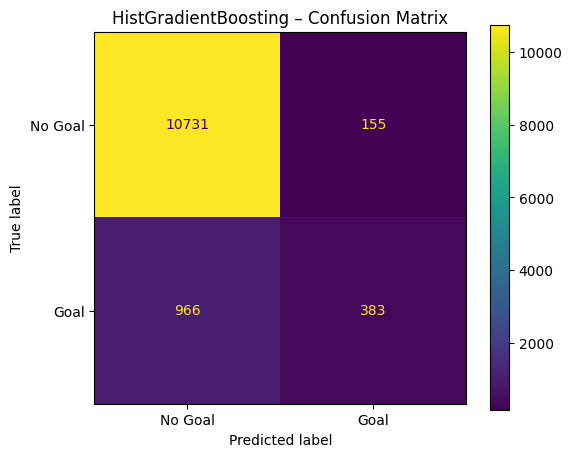

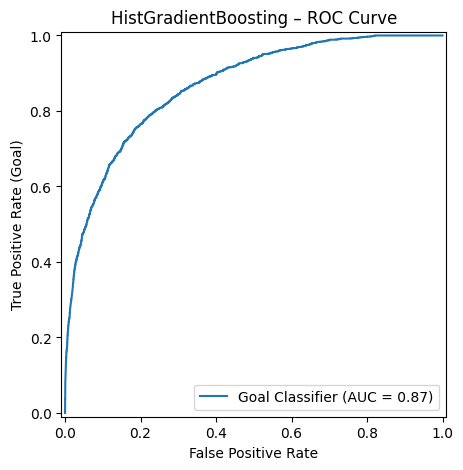

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np

best_name = "HistGradientBoosting"
best_model = fitted_models[best_name]

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(6, 5))

cm = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["No Goal", "Goal"],
    ax=ax,
)

plt.title(f"{best_name} – Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))

roc = RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
    name="Goal Classifier",
    ax=ax
)

plt.title(f"{best_name} – ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Goal)")
plt.show()

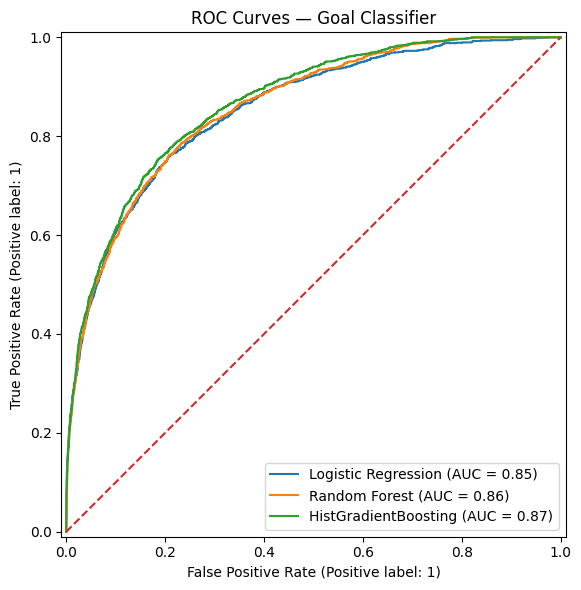

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        y_proba = model.predict(X_test).astype(float)

    RocCurveDisplay.from_predictions(
        y_test,
        y_proba,
        name=name,
        ax=ax,
    )

ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curves — Goal Classifier")
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

def inspect_misclassifications(model, X_test, y_test, original_df):
    """
    model: fitted classifier
    X_test: features DF
    y_test: Series of true labels
    original_df: the full shots DF (must align row indices with X_test)
    """

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results = pd.DataFrame({
        "y_true": y_test,
        "y_pred": y_pred,
        "proba": y_proba,
    }, index=X_test.index)

    results = results.join(original_df, how="left")

    # -False Negatives (Actual goal, predicted no goal)
    fn = results[(results.y_true == 1) & (results.y_pred == 0)].copy()
    fn = fn.sort_values("proba")

    print("FALSE NEGATIVES: Actual GOAL, Predicted NO GOAL")
    print(f"Count: {len(fn)}\n")

    display(fn[
        [
            "player_name", "minute",
            "shot_x", "shot_y",
            "distance_to_goal", "shot_angle",
            "shot_statsbomb_xg",
            "under_pressure_num",
            "proba", "y_pred", "y_true"
        ]
    ].head(50))

    # False Positives (Actual no goal, predicted goal)
    fp = results[(results.y_true == 0) & (results.y_pred == 1)].copy()
    fp = fp.sort_values("proba", ascending=False)

    print("FALSE POSITIVES: Actual NO GOAL, Predicted GOAL")
    print(f"Count: {len(fp)}\n")

    display(fp[
        [
            "player_name", "minute",
            "shot_x", "shot_y",
            "distance_to_goal", "shot_angle",
            "shot_statsbomb_xg",
            "under_pressure_num",
            "proba", "y_pred", "y_true"
        ]
    ].head(50))

    return fn, fp

best_model = fitted_models["HistGradientBoosting"]

fn, fp = inspect_misclassifications(best_model, X_test, y_test, shots_geo)

FALSE NEGATIVES: Actual GOAL, Predicted NO GOAL
Count: 966



,player_name,minute,shot_x,shot_y,distance_to_goal,shot_angle,shot_statsbomb_xg,under_pressure_num,proba,y_pred,y_true
29471,Florian Grillitsch,42,97.5,28.5,25.268558,0.287687,0.024896,1,0.009141,0,1
58522,Ryder Matos Santos,87,100.1,54.3,24.505102,0.296521,0.025140,1,0.009177,0,1
18470,Matt Ritchie,8,94.2,33.6,26.581949,0.273654,0.019833,0,0.009545,0,1
13661,Martin Braithwaite Christensen,25,89.5,52.0,32.775753,0.222414,0.020419,0,0.009900,0,1
35861,Thiago Motta,70,95.0,58.4,31.041263,0.234731,0.010350,0,0.010535,0,1
21988,Harry Arter,16,93.7,40.4,26.303042,0.276519,0.033008,0,0.011140,0,1
29855,Änis Ben-Hatira,32,117.0,51.7,12.078493,0.588446,0.023878,0,0.011655,0,1
1893,Seko Fofana,61,90.2,49.4,31.247400,0.233197,0.022808,0,0.012042,0,1
38906,Giuseppe Rossi,22,103.4,62.7,28.122055,0.258839,0.009034,0,0.012176,0,1
13253,Claudio Beauvue,86,105.9,59.9,24.388932,0.297913,0.010286,1,0.012987,0,1


FALSE POSITIVES: Actual NO GOAL, Predicted GOAL
Count: 155



,player_name,minute,shot_x,shot_y,distance_to_goal,shot_angle,shot_statsbomb_xg,under_pressure_num,proba,y_pred,y_true
16011,Rafael Mir Vicente,56,119.3,42.5,2.596151,1.907671,0.866592,0,0.904790,1,0
28735,Anthony Ujah,90,116.8,43.9,5.044799,1.255271,0.904446,0,0.892732,1,0
29129,Gustavo Adrián Ramos Vásquez,73,109.8,39.8,10.201961,0.688905,0.837382,0,0.889626,1,0
18642,Aleksandar Mitrović,18,112.8,43.9,8.188406,0.840668,0.839297,0,0.863886,1,0
21745,Enner Remberto Valencia Lastra,30,116.6,39.6,3.423449,1.637561,0.603720,0,0.848899,1,0
53311,Paulo Bruno Exequiel Dybala,6,109.9,38.6,10.196568,0.689241,0.747586,0,0.823515,1,0
57054,Alberto Gilardino,87,111.6,39.7,8.405355,0.821355,0.645854,0,0.818574,1,0
34336,Thomas Müller,20,108.0,40.0,12.000000,0.592075,0.783500,0,0.813854,1,0
33953,Marco Reus,46,108.1,40.1,11.900420,0.596742,0.783500,0,0.813806,1,0
16326,Frenkie de Jong,15,118.7,44.0,4.205948,1.432206,0.796576,0,0.811825,1,0


In [14]:
import os
import re
import pandas as pd

EVENTS_DIR = "/content/events"

# Regex to extract competition_id and season_id from filenames
pattern = re.compile(r"events_comp(\d+)_season(\d+)\.parquet")

file_info = []

for fname in os.listdir(EVENTS_DIR):
    if fname.endswith(".parquet"):
        match = pattern.match(fname)
        if match:
            comp = int(match.group(1))
            season = int(match.group(2))
            file_info.append((fname, comp, season))

df_files = pd.DataFrame(file_info, columns=["filename", "competition_id", "season_id"])

print("==============================================")
print("             COMPETITION FILE CHECK           ")
print("==============================================")
print(f"Total parquet files inside /events: {len(df_files)}")
print(f"Unique competitions found: {df_files['competition_id'].nunique()}")
print("List of competition IDs detected:")
print(sorted(df_files["competition_id"].unique()))
print("==============================================")
print("Sample of loaded files:")
print(df_files.head(10))
print("==============================================")

expected_count = 75
print(f"Expected number of files: {expected_count}")
print(f"Difference: {expected_count - len(df_files)} (positive = missing, negative = extra)")

             COMPETITION FILE CHECK           
Total parquet files inside /events: 75
Unique competitions found: 21
List of competition IDs detected:
[np.int64(2), np.int64(7), np.int64(9), np.int64(11), np.int64(12), np.int64(16), np.int64(35), np.int64(37), np.int64(43), np.int64(44), np.int64(49), np.int64(53), np.int64(55), np.int64(72), np.int64(81), np.int64(87), np.int64(116), np.int64(223), np.int64(1238), np.int64(1267), np.int64(1470)]
Sample of loaded files:
                          filename  competition_id  season_id
0   events_comp16_season27.parquet              16         27
1   events_comp35_season75.parquet              35         75
2    events_comp11_season4.parquet              11          4
3   events_comp7_season235.parquet               7        235
4  events_comp43_season272.parquet              43        272
5   events_comp7_season108.parquet               7        108
6   events_comp16_season44.parquet              16         44
7   events_comp11_season39.par